In [3]:
import os
from pathlib import Path
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# === 1. Set your local dataset folder path ===
dataset_folder = Path("E:\cse366_research\myenv\MRI\Training")  # Change this to your actual path

# === 2. Define common transform (like rescale and resize) ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Scales pixel values to [0, 1]
])

# === 3. Load full dataset ===
full_dataset = datasets.ImageFolder(root=str(dataset_folder), transform=transform)
total_images = len(full_dataset)
num_classes = len(full_dataset.classes)

# === 4. Create 80/20 split ===
train_size = int(0.8 * total_images)
val_size = total_images - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# === 5. Create DataLoaders ===
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# === 6. Print output to match TensorFlow format ===
print(f"Found {len(train_dataset)} images belonging to {num_classes} classes.")
print(f"Found {len(val_dataset)} images belonging to {num_classes} classes.")


Found 4569 images belonging to 4 classes.
Found 1143 images belonging to 4 classes.


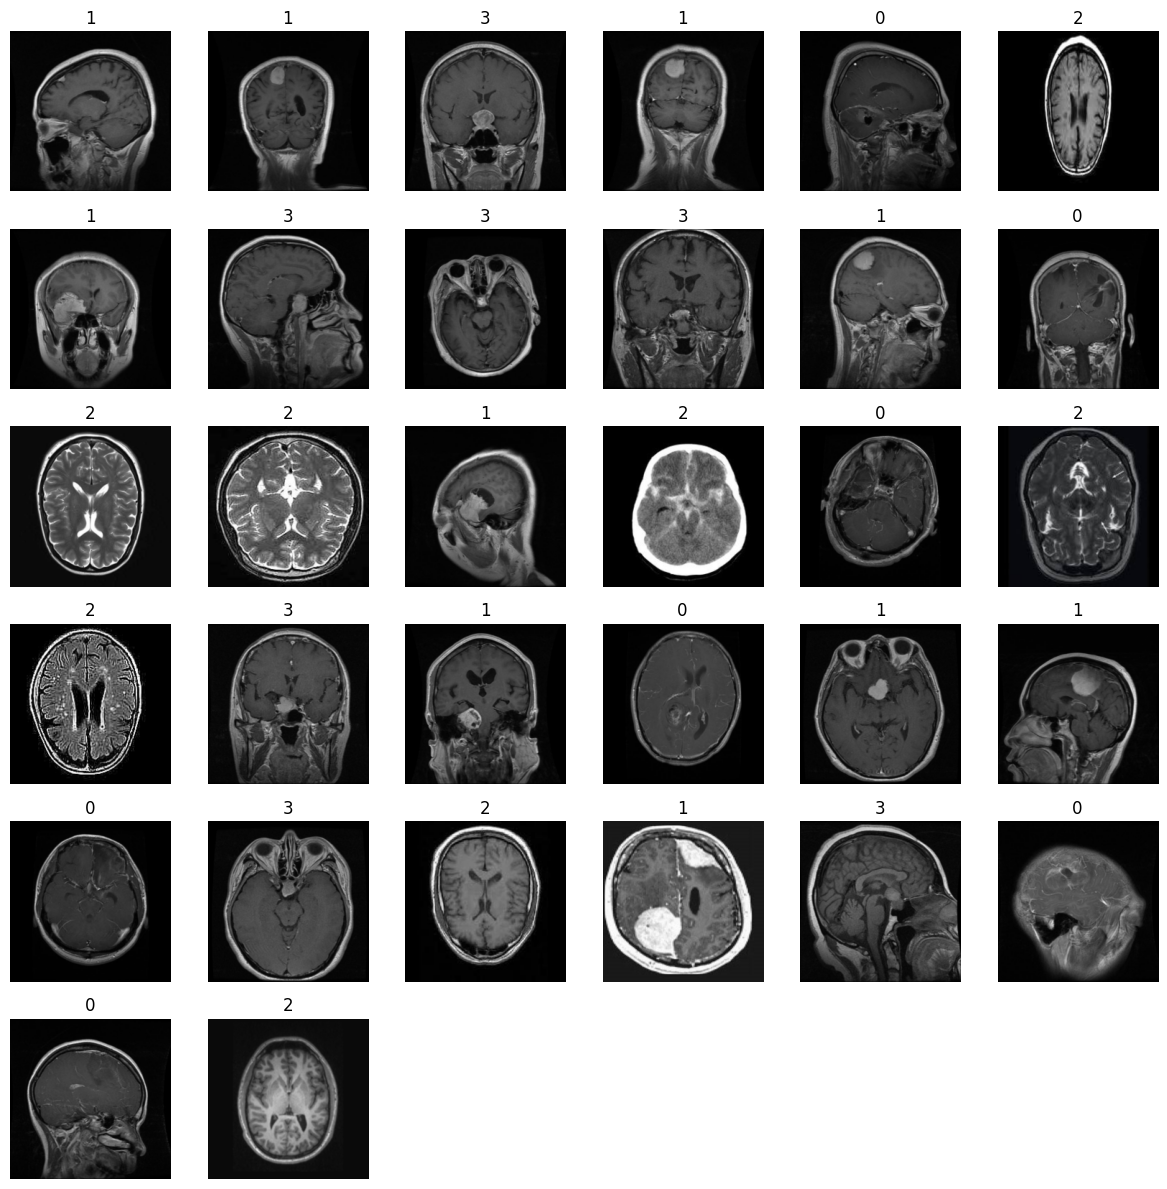

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# === Step 1: Get one batch of images and labels from the validation loader ===
images, labels = next(iter(val_loader))  # One batch

# === Step 2: Choose number of images to display (max 32) ===
count = min(32, images.shape[0])

# === Step 3: Plot images ===
plt.figure(figsize=(12, 12))
for i in range(count):
    plt.subplot(6, 6, i + 1)
    
    # Convert from torch tensor to numpy image for display
    img_np = images[i].permute(1, 2, 0).numpy()
    
    # Since ToTensor() scales [0, 255] to [0, 1], no need to rescale
    plt.imshow(img_np)
    plt.title(str(labels[i].item()))  # Class index
    plt.axis('off')

plt.tight_layout()
plt.show()


Pixel range: 0.0 1.0


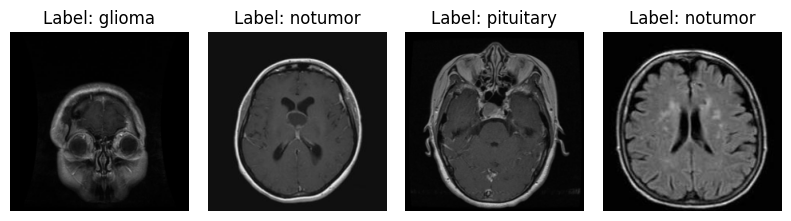

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets

# === 1. Get class names from the full dataset ===
class_names = full_dataset.classes  # Example: ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# === 2. Get one batch from the validation loader ===
images, labels = next(iter(val_loader))  # [B, C, H, W]

# === 3. Check pixel value range ===
print("Pixel range:", torch.min(images).item(), torch.max(images).item())  # Should be 0.0 to 1.0

# === 4. Plot sample images with class names ===
plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(6, 6, i + 1)
    img = images[i].permute(1, 2, 0).numpy()  # [H, W, C]
    plt.imshow(img)
    plt.title(f"Label: {class_names[labels[i].item()]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [10]:
pip install torchsummary


  Using cached torchsummary-1.5.1-py3-none-any.whl.metadata (296 bytes)
Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)
Note: you may need to restart the kernel to use updated packages.


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary

class ResNet50_EfficientNetB0(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.5):
        super(ResNet50_EfficientNetB0, self).__init__()

        # Load pretrained models without classifier layers
        self.resnet = models.resnet50(pretrained=True)
        self.efficientnet = models.efficientnet_b0(pretrained=True)

        # Freeze their parameters
        for param in self.resnet.parameters():
            param.requires_grad = False
        for param in self.efficientnet.parameters():
            param.requires_grad = False

        # Remove the classifier layers
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        self.efficientnet = nn.Sequential(*list(self.efficientnet.children())[:-2])

        # Global Average Pooling layers
        self.gap_resnet = nn.AdaptiveAvgPool2d((1, 1))
        self.gap_effnet = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(2048 + 1280, 256)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(128, num_classes)

    def forward(self, x):
        # Feature extraction
        x1 = self.resnet(x)
        x2 = self.efficientnet(x)

        # Global average pooling
        x1 = self.gap_resnet(x1)
        x2 = self.gap_effnet(x2)

        # Flatten
        x1 = torch.flatten(x1, 1)
        x2 = torch.flatten(x2, 1)

        # Concatenate
        x = torch.cat((x1, x2), dim=1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.out(x)
        return F.softmax(x, dim=1)

# Instantiate the model
model = ResNet50_EfficientNetB0(num_classes=4)

# Summary of the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, (3, 224, 224))

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# You can then continue with training using a PyTorch DataLoader for `dataflowtraining` and `dataflowvalidation`


e:\cse366_research\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\cse366_research\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [01:26<00:00, 1.19MB/s]
e:\cse366_research\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 an

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [14]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model =  ResNet50_EfficientNetB0(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, accuracy_score
import numpy as np
from torch.optim.lr_scheduler import StepLR

# Early stopping helper class
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.patience_counter = 0

    def should_stop(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.patience_counter = 0
            return False
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                return True
            return False

# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet50_EfficientNetB0(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Early stopping setup
early_stopping = EarlyStopping(patience=3, delta=0)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        # Train phase
        model.train()
        train_loss, train_preds, train_labels = 0, [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Calculate train metrics
        train_acc = accuracy_score(train_labels, train_preds)
        train_precision = precision_score(train_labels, train_preds, average='macro', zero_division=0)
        train_recall = recall_score(train_labels, train_preds, average='macro', zero_division=0)

        # Validation phase
        model.eval()
        val_loss, val_preds, val_labels = 0, [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Calculate validation metrics
        val_acc = accuracy_score(val_labels, val_preds)
        val_precision = precision_score(val_labels, val_preds, average='macro', zero_division=0)
        val_recall = recall_score(val_labels, val_preds, average='macro', zero_division=0)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f} | Precision: {train_precision:.4f} | Recall: {train_recall:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f} | Precision: {val_precision:.4f} | Recall: {val_recall:.4f}")

        # Step the scheduler (learning rate decay)
        scheduler.step()

        # Check early stopping condition
        if early_stopping.should_stop(val_loss):
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break


In [21]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Assuming datasetfolder is your image folder
train_dataset = datasets.ImageFolder(root=dataset_folder , transform=transform)
val_dataset = datasets.ImageFolder(root=dataset_folder , transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50)


Epoch 1/50
Train Loss: 146.7989 | Accuracy: 0.9245 | Precision: 0.9231 | Recall: 0.9209
Val   Loss: 143.2164 | Accuracy: 0.9429 | Precision: 0.9444 | Recall: 0.9394
Epoch 2/50
Train Loss: 146.3085 | Accuracy: 0.9261 | Precision: 0.9252 | Recall: 0.9230
Val   Loss: 141.9931 | Accuracy: 0.9496 | Precision: 0.9488 | Recall: 0.9467
Epoch 3/50
Train Loss: 145.8191 | Accuracy: 0.9291 | Precision: 0.9282 | Recall: 0.9259
Val   Loss: 142.8239 | Accuracy: 0.9454 | Precision: 0.9471 | Recall: 0.9421
Epoch 4/50
Train Loss: 146.3197 | Accuracy: 0.9259 | Precision: 0.9248 | Recall: 0.9224
Val   Loss: 141.6585 | Accuracy: 0.9522 | Precision: 0.9525 | Recall: 0.9496
Epoch 5/50
Train Loss: 145.1551 | Accuracy: 0.9333 | Precision: 0.9322 | Recall: 0.9305
Val   Loss: 141.9085 | Accuracy: 0.9503 | Precision: 0.9511 | Recall: 0.9475
Epoch 6/50
Train Loss: 144.5614 | Accuracy: 0.9373 | Precision: 0.9363 | Recall: 0.9345
Val   Loss: 141.3972 | Accuracy: 0.9534 | Precision: 0.9536 | Recall: 0.9509
Epoch 7/50